In order to build an agentic application, we need to give it access to possible courses of action so that it can make a decision given some context about the current state or some desired next state.

### Building a LangGraph agent

In [14]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [7]:
@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be mathematical expression."""
    return ast.literal_eval(query)

In [9]:
search = DuckDuckGoSearchRun()
tools = [search, calculator]
model = ChatOpenAI(temperature=0.1).bind_tools(tools)

In [10]:
class State(TypedDict):
    messages: Annotated[str, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

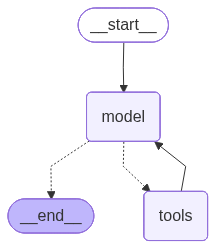

In [12]:
builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()
graph

In [15]:
input = {
 "messages": [
 HumanMessage("""How old was the 30th president of the United States when he died?""")
 ]
}
for c in graph.stream(input):
 print(c)

{'model': {'messages': AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 121, 'total_tokens': 150, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Co51eGzCStHvcPicQOmkpAVKFYFoO', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--83b87794-d8b1-4150-ae75-6fa6fedfe032-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Age of the 30th president of the United States at death'}, 'id': 'call_z8ppL3STGO8lUlPmdjoIXF6w', 'type': 'tool_call'}], usage_metadata={'input_tokens': 121, 'output_tokens': 29, 'total_tokens': 150, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': 